# Simple Character-level Language Model using ANN
2017-04-11 jkang  
Python3.5  
TensorFlow1.0.1  
  
- input:  &nbsp;&nbsp;'hello_world_good_morning_see_you_hello_grea'  
- output: 'ello_world_good_morning_see_you_hello_great'  

### Reference:  
- https://github.com/aymericdamien/TensorFlow-Examples
- https://hunkim.github.io/ml/

### Comment:
- one character --> one character 맵핑을 함
- 애초에 ANN구조상 문맥정보를 활용할 수 없기에, 예측이 엉망일 수밖에 없는 것으로 생각됨
- char2vec, word2vec 등으로 인풋을 준비한다면, 문맥정보가 feature에 담겨 있으므로, 이를 활용하면 정확도가 올라갈 것으로 생각됨. 하지만 여전히 시간정보 (곧 문맥정보)가 ANN에서는 명시적으로 모델링 되지 않아서 불완전한 모델링이 될 것으로 보임

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Input/Ouput data
char_raw = 'hello_world_good_morning_see_you_hello_great'
char_list = list(set(char_raw))
char_to_idx = {c: i for i, c in enumerate(char_list)}
idx_to_char = {i: c for i, c in enumerate(char_list)}
char_data = [char_to_idx[c] for c in char_raw]
char_data_one_hot = tf.one_hot(char_data, depth=len(
    char_list), on_value=1., off_value=0., axis=1, dtype=tf.float32)
char_input = char_data_one_hot[:-1, :]  # 'hello_world_good_morning_see_you_hello_grea'
char_output = char_data_one_hot[1:, :]  # 'ello_world_good_morning_see_you_hello_great'
with tf.Session() as sess:
    char_input = char_input.eval()
    char_output = char_output.eval()

In [2]:
# Parameters
learning_rate = 0.001
max_iter = 200

# Network Parameters
n_hidden_1 = 256 # 1st hidden layer number of features (neurons)
n_hidden_2 = 256 # 2nd hidden layer number of features (neurons)
n_input = char_input.shape[1] # input features
n_output = char_input.shape[1] # output features

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_output])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return tf.tanh(out_layer)

In [3]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

def softmax(x):
    rowmax = np.max(x, axis=1)
    x -= rowmax.reshape((x.shape[0] ,1)) # for numerical stability
    x = np.exp(x)
    sum_x = np.sum(x, axis=1).reshape((x.shape[0],1))
    return x / sum_x

In [4]:
# Learning (online training)
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    pred_act = np.empty((0,17))
    for i in range(max_iter):
        avg_cost = 0.
        total_chars = len(char_input)
        pred_seq = []
        # Loop over all characters
        for c in range(total_chars):
            train_x = char_input[c,:].reshape((-1,n_input))
            train_y = char_output[c,:].reshape((-1,n_output))
            _, l, p = sess.run([optimizer, cost, pred], 
                               feed_dict={x: train_x, y: train_y})
            if i is max_iter-1:
                pred_act = np.vstack((pred_act, p))
            pred_out = int(np.argmax(p, axis=1))
            pred_seq.append(idx_to_char[pred_out])
            # Compute average loss
            avg_cost += l / total_chars
        # Display logs per epoch step
        print('Epoch: {:>4}'.format(i+1), 
              'Cost: {:4f}'.format(avg_cost), 
              'Predict:', ''.join(pred_seq))
    pred_act = softmax(pred_act)

Epoch:    1 Cost: 3.438902 Predict: aaaaaaaaaaaaaaaaaaaaawaaaaaaaaaaaaaaaaaaaaa
Epoch:    2 Cost: 3.249028 Predict: aaaaaaaaaaaaaaaaaaaaawaaaaaaaaaaaaaaaaaaaaa
Epoch:    3 Cost: 3.098925 Predict: aaaaaaaaaaaaaaaaaaaaahaaaaaaaaaaaaaaaaaaaaa
Epoch:    4 Cost: 2.967775 Predict: aaaaaaaaaaaaaaaaaaaaahaaaaaaaaaaaaaaaaaaaaa
Epoch:    5 Cost: 2.911683 Predict: aaaaaaaaaaaaaaaaaaaaaohaaaaaaaaaaawaaaaaaha
Epoch:    6 Cost: 2.874949 Predict: aaaaaaaaaahaaaahaaaahohaaaooaaaaahwaaaaaawa
Epoch:    7 Cost: 2.855519 Predict: hhaaaaaaaahaaaahaaaahohaaawhaaaaawwaaaaaawa
Epoch:    8 Cost: 2.813224 Predict: wwaaaaaaaahaaaawaaaawowaawowaoawawonnaaaaow
Epoch:    9 Cost: 2.771241 Predict: wwnnaawaanwaaaawaaaawowaawwwaowwawwnnwtwwww
Epoch:   10 Cost: 2.681875 Predict: wonnwtwwanwtwwwwtlwawowwawwwtowwtwwnnwtwaww
Epoch:   11 Cost: 2.651154 Predict: wwnnwtwwanwtwwwwtlwawowwtwootowwtwwnnwtwwww
Epoch:   12 Cost: 2.632099 Predict: wwnnwtwwanwtwwwwtlwwwowwtwwotowwtwwnnwtwwww
Epoch:   13 Cost: 2.603506 Predict: wwnn

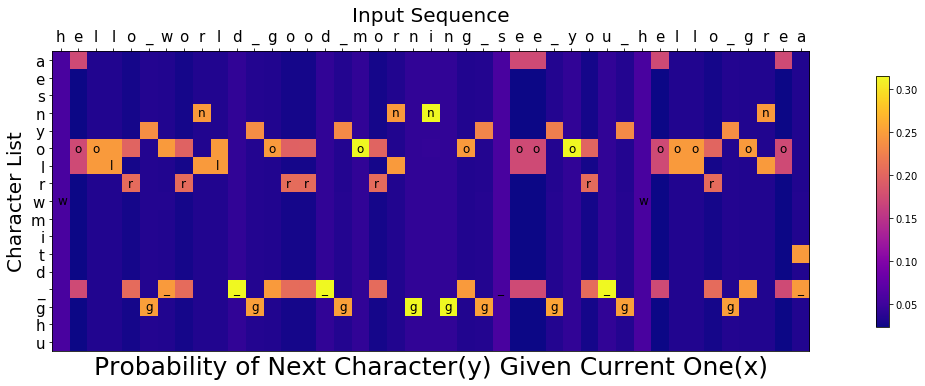

In [5]:
# Probability plot
fig, ax = plt.subplots()
fig.set_size_inches(15,20)
plt.title('Input Sequence', y=1.08, fontsize=20)
plt.xlabel('Probability of Next Character(y) Given Current One(x)', fontsize=25, y=1.5)
plt.ylabel('Character List', fontsize=20)
plot = plt.imshow(pred_act.T, cmap=plt.get_cmap('plasma'))
cbar = fig.colorbar(plot, fraction=0.015, pad=0.08)
plt.xticks(np.arange(len(char_data)-1), list(char_raw)[:-1], fontsize=15)
plt.yticks(np.arange(len(char_list)), [idx_to_char[i] for i in range(len(char_list))], fontsize=15)
ax.xaxis.tick_top()

# Annotate
for i, c in zip(range(len(pred_seq)), pred_seq):
    idx = char_to_idx[c]
    ax.annotate(c, xy=(i-0.2, idx+0.2), fontsize=12)
    
plt.show()

### Result:
- WRONG!!